In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
pip install huggingface_hub[hf_xet]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 MB 15.6 MB/s eta 0:00:00


In [ ]:
pip install -U transformers


In [ ]:
dataset = load_dataset("imdb")

train_dataset = dataset["train"].shuffle(seed=42).select(range(5000))
test_dataset = dataset["test"].shuffle(seed=42).select(range(1000))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
train_df = dataset['train'].to_pandas()
print(train_df.head())

                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=256,
        padding="max_length"
    )

In [ ]:
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])
tokenized_train.set_format("torch")
tokenized_test.set_format("torch")

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }


In [ ]:
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to(device)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

base_training_args = TrainingArguments(
    output_dir="./base-model",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    logging_dir='./logs_base',
    report_to=[],
    remove_unused_columns=False,
)

base_trainer = Trainer(
    model=base_model,
    args=base_training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("\nEvaluating Base Model (No LoRA)...")
base_trainer.train()
base_results = base_trainer.evaluate()
print(f"\nBase model results: {base_results}")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-14-5fcfa0538cbd>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  base_trainer = Trainer(



Evaluating Base Model (No LoRA)...


Step,Training Loss



Base model results: {'eval_loss': 0.27740317583084106, 'eval_accuracy': 0.884, 'eval_f1': 0.8828282828282829, 'eval_precision': 0.8705179282868526, 'eval_recall': 0.8954918032786885, 'eval_runtime': 6.534, 'eval_samples_per_second': 153.045, 'eval_steps_per_second': 9.642, 'epoch': 1.0}


In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=64,
    lora_dropout=0.1,
    target_modules=["q_lin", "v_lin", "ffn.lin1", "ffn.lin2"],
    bias="none",
    inference_mode=False
)

lora_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to(device)

lora_model = get_peft_model(lora_model, peft_config)
lora_model.print_trainable_parameters()

lora_training_args = TrainingArguments(
    output_dir="./lora-model",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir='./logs_lora',
    remove_unused_columns=False,
    report_to=[]
)

lora_trainer = Trainer(
    model=lora_model,
    args=lora_training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("\nTraining LoRA Fine-Tuned Model...")
lora_trainer.train()
lora_results = lora_trainer.evaluate()
print(f"\nLoRA model results: {lora_results}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-15-144f30406a5d>:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 1,108,226 || all params: 68,063,236 || trainable%: 1.6282

Training LoRA Fine-Tuned Model...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.353636,0.848000,0.858473,0.786689,0.944672
2,0.341600,0.332585,0.865000,0.870566,0.818018,0.930328
3,0.341600,0.304800,0.878000,0.878728,0.853282,0.905738



LoRA model results: {'eval_loss': 0.3048000633716583, 'eval_accuracy': 0.878, 'eval_f1': 0.878727634194831, 'eval_precision': 0.8532818532818532, 'eval_recall': 0.9057377049180327, 'eval_runtime': 7.7248, 'eval_samples_per_second': 129.454, 'eval_steps_per_second': 8.156, 'epoch': 3.0}


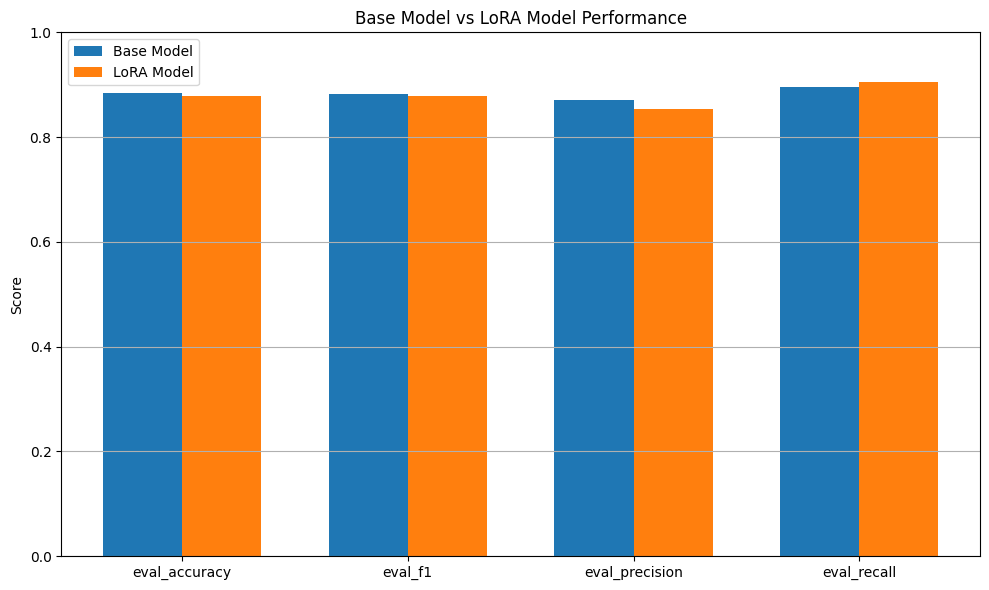

In [ ]:
metrics = [ "eval_accuracy","eval_f1", "eval_precision", "eval_recall"]
base_scores = [base_results[m] for m in metrics]
lora_scores = [lora_results[m] for m in metrics]
labels = [m.replace("eval_", "").capitalize() for m in metrics]
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, base_scores, width, label='Base Model')
plt.bar(x + width/2, lora_scores, width, label='LoRA Model')

plt.ylabel('Score')
plt.title('Base Model vs LoRA Model Performance')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


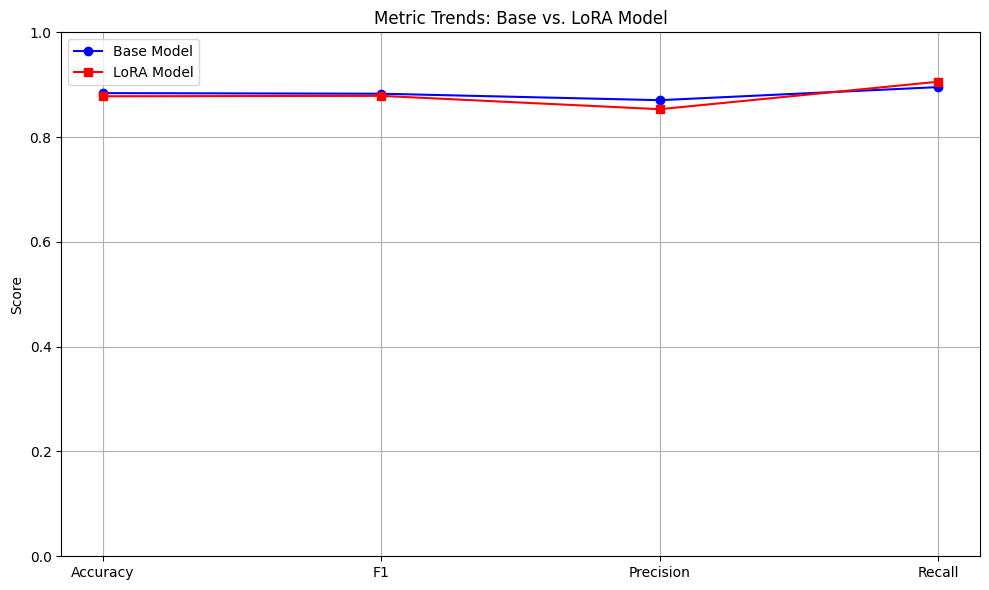

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(labels, base_scores, marker='o', label='Base Model', color='blue')
plt.plot(labels, lora_scores, marker='s', label='LoRA Model', color='red')
plt.title('Metric Trends: Base vs. LoRA Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
def predict_sentiment(text,mod):
    if mod == "base":
        model = base_model
    else:
        model = lora_model
    model.to(device)
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=256,
        padding="max_length"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    probs = probs.cpu()

    return {
        "text": text,
        "sentiment": "positive" if probs.argmax().item() == 1 else "negative",
        "confidence": probs.max().item(),
        "probabilities": {
            "negative": probs[0][0].item(),
            "positive": probs[0][1].item()
        }
    }

100%|██████████| 25000/25000 [05:07<00:00, 81.21it/s]


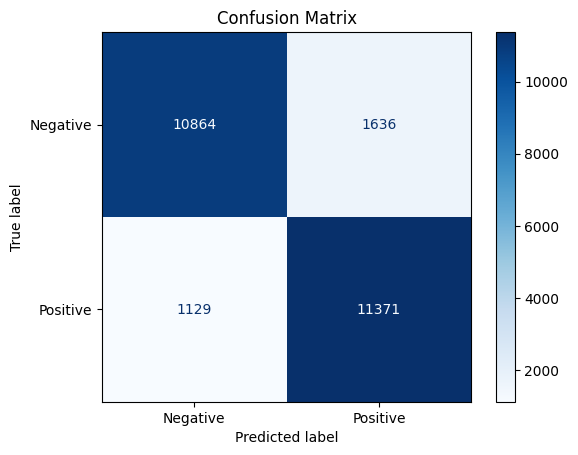

In [ ]:
true_labels = ["positive" if label == 1 else "negative" for label in dataset['test']['label']]

test_texts = dataset['test']['text']

predicted_labels = []

for text in tqdm(test_texts):
    result = predict_sentiment(text,mod="lora")
    predicted_labels.append(result["sentiment"])

cm = confusion_matrix(true_labels, predicted_labels, labels=["negative", "positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


100%|██████████| 25000/25000 [04:10<00:00, 99.96it/s] 


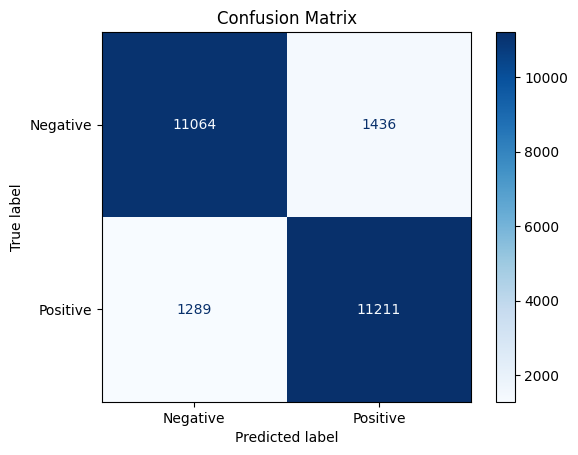

In [ ]:
true_labels = ["positive" if label == 1 else "negative" for label in dataset['test']['label']]

test_texts = dataset['test']['text']

predicted_labels = []

for text in tqdm(test_texts):
    result = predict_sentiment(text,mod="base")
    predicted_labels.append(result["sentiment"])

cm = confusion_matrix(true_labels, predicted_labels, labels=["negative", "positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
sample_reviews = [
    "This movie was absolutely fantastic! The acting was superb.",
    "I hated every minute of this film. Terrible plot and bad acting.",
    "It was okay. Not great but not terrible either.",
    "I Love alnasser movie but it hurts me"
]

for review in sample_reviews:
    result = predict_sentiment(review,mod = "lora")
    print("\nStructured Output:")
    print(result)



Structured Output:
{'text': 'This movie was absolutely fantastic! The acting was superb.', 'sentiment': 'positive', 'confidence': 0.9945386052131653, 'probabilities': {'negative': 0.005461379885673523, 'positive': 0.9945386052131653}}

Structured Output:
{'text': 'I hated every minute of this film. Terrible plot and bad acting.', 'sentiment': 'negative', 'confidence': 0.994540274143219, 'probabilities': {'negative': 0.994540274143219, 'positive': 0.005459693726152182}}

Structured Output:
{'text': 'It was okay. Not great but not terrible either.', 'sentiment': 'positive', 'confidence': 0.8721327781677246, 'probabilities': {'negative': 0.12786728143692017, 'positive': 0.8721327781677246}}

Structured Output:
{'text': 'I Love alnasser movie but it hurts me', 'sentiment': 'negative', 'confidence': 0.572821319103241, 'probabilities': {'negative': 0.572821319103241, 'positive': 0.42717868089675903}}


In [ ]:
rev = input("Enter a review: ")
res = predict_sentiment(rev,mod = "lora")
print("\nStructured Output:")
print(res)

Enter a review: I hate watching horror movies

Structured Output:
{'text': 'I hate watching horror movies', 'sentiment': 'negative', 'confidence': 0.9275122284889221, 'probabilities': {'negative': 0.9275122284889221, 'positive': 0.07248780876398087}}
